In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Рассмотрим регрессиюна решающих деревьях 

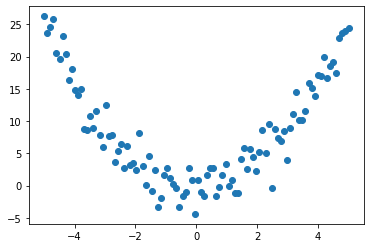

In [2]:
np.random.seed(42)
N = 100
x = np.linspace(-5.0, 5.0, N)
y = x**2 + np.random.normal(scale=2.5, size=N)
plt.scatter(x,y)
plt.show()

In [3]:
reg = DecisionTreeRegressor(max_depth=5)


reg.fit(x.reshape(N,1),y)
y_pred = reg.predict(x.reshape(N,1))

### Приближает кусочно-постоянными

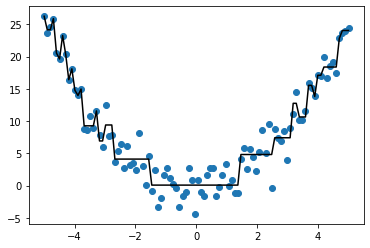

In [4]:
plt.scatter(x,y)
plt.plot(x, y_pred, 'k')
plt.show()

In [5]:
print(export_text(reg))

|--- feature_0 <= -3.74
|   |--- feature_0 <= -4.24
|   |   |--- feature_0 <= -4.65
|   |   |   |--- feature_0 <= -4.95
|   |   |   |   |--- value: [26.24]
|   |   |   |--- feature_0 >  -4.95
|   |   |   |   |--- feature_0 <= -4.75
|   |   |   |   |   |--- value: [24.15]
|   |   |   |   |--- feature_0 >  -4.75
|   |   |   |   |   |--- value: [25.87]
|   |   |--- feature_0 >  -4.65
|   |   |   |--- feature_0 <= -4.44
|   |   |   |   |--- feature_0 <= -4.55
|   |   |   |   |   |--- value: [20.54]
|   |   |   |   |--- feature_0 >  -4.55
|   |   |   |   |   |--- value: [19.62]
|   |   |   |--- feature_0 >  -4.44
|   |   |   |   |--- feature_0 <= -4.34
|   |   |   |   |   |--- value: [23.25]
|   |   |   |   |--- feature_0 >  -4.34
|   |   |   |   |   |--- value: [20.35]
|   |--- feature_0 >  -4.24
|   |   |--- feature_0 <= -4.04
|   |   |   |--- feature_0 <= -4.14
|   |   |   |   |--- value: [16.40]
|   |   |   |--- feature_0 >  -4.14
|   |   |   |   |--- value: [18.09]
|   |   |--- feature

### Подбор параметров с помощью GridSearch

In [6]:
reg = DecisionTreeRegressor(max_depth=6, min_samples_leaf=2)
reg.fit(x.reshape(N,1),y)
y_pred = reg.predict(x.reshape(N,1))

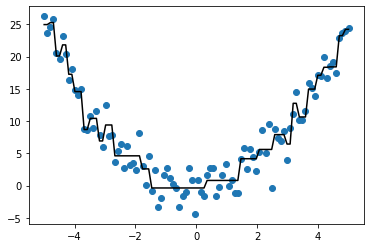

In [7]:
plt.scatter(x,y)
plt.plot(x, y_pred, 'k')
plt.show()

## Эд, помни, деревья валятся на экстраполяции

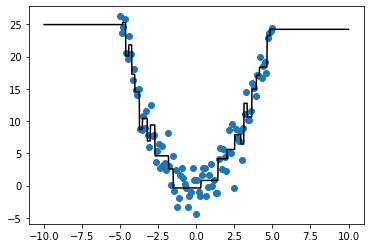

In [8]:
x_new = np.linspace(-10.0, 10.0, 1000)
y_pred = reg.predict(x_new.reshape(1000,1))
plt.scatter(x,y)
plt.plot(x_new, y_pred, 'k')
plt.show()

#  Ансамбль

## Предсказание ансамбля - это предсказание большинства

## Датасет moons

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings("ignore")

In [10]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [12]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42) 
tree_clf = DecisionTreeClassifier(random_state=42) 
svm_clf = SVC(gamma="scale", random_state=42, probability=True)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('tree', tree_clf), ('svc', svm_clf)], 
                              voting='soft')

In [13]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.896
VotingClassifier 0.912


Видно, что ансамбль справляется чуть лучше, чем каждый из его элементов в отдельности

##  Voting  hard или soft
* Hard - это голосование по предсказанию меток классов
* Soft - это голосование по вероятности принадлежности к классу

## А еще может быть ансамбль алгортитмов одного типа

Если обучать каждый из них на случайной подвыборке трейн сета. Различают сэмплинг подвыборок:
- C возвратом (bagging) 
- Без возврата (pasting)

## Пример: BaggingClassifier на деревьях

In [14]:
from sklearn.ensemble import BaggingClassifier

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
bag_clf = BaggingClassifier(tree_clf, n_estimators=500, 
                            max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train) 
tree_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
print("Bagging: ", accuracy_score(y_test, y_pred_bag))
print("Tree: ", accuracy_score(y_test, y_pred_tree))

Bagging:  0.904
Tree:  0.856


In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

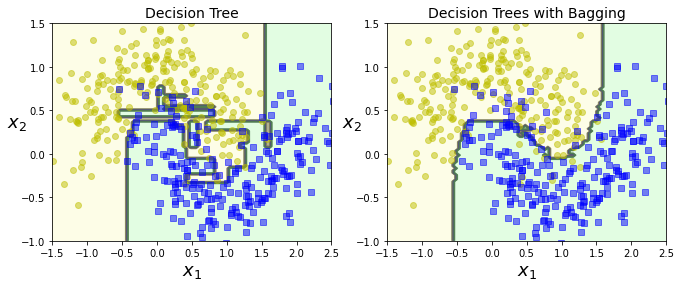

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## RandomForest есть BaggingClassifier на решающих деревьях 


In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rndf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                  bootstrap=True, n_jobs=-1, random_state=42)
rndf_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [20]:
y_pred = rndf_clf.predict(X_test)
print("RandomForest: ", accuracy_score(y_test, y_pred))

RandomForest:  0.912


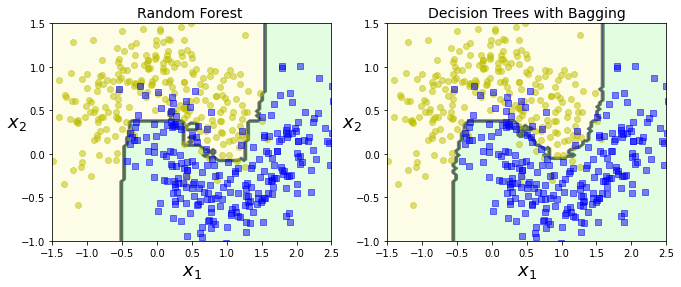

In [21]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(rndf_clf, X, y)
plt.title("Random Forest ", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Одна из фишек RandomForest - умение вычислять важность признака для классификации

Важность признака - это частота событий, когда разделение деревом имеющегося набора данных по этому признаку приводит к повышению "чистоты" получившихся подмножеств. Но я знаю что на самом деле все содержится в энтропии.

In [22]:
from sklearn.datasets import load_iris

In [23]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11144162828196508
sepal width (cm) 0.022843209786633224
petal length (cm) 0.414292078686009
petal width (cm) 0.45142308324539276


## Пример вычисления важности признаков на датасете MNIST